### Multi-Bandwidth Audio Tokenization Study

This script demonstrates how audio quality varies with compression bandwidth using EnCodec's neural codec. It processes input audio at different bitrates (1.5, 6, 12 kbps) to showcase compression artifacts and tokenization efficiency.

Key Libraries Used:

    encodec: Core neural codec for tokenization/reconstruction

    torch/torchaudio: Audio tensor processing and resampling

    soundfile (sf): Audio file I/O operations

    numpy (np): Signal generation and math operations

    os: File system management

Code Logic and Flow

The pipeline:

    Generates fallback audio if input is missing

    Processes audio at multiple bandwidths sequentially

    For each bandwidth:

        Configures EnCodec model

        Tokenizes audio to discrete representations

        Reconstructs waveform from tokens

    Saves outputs for quality comparison

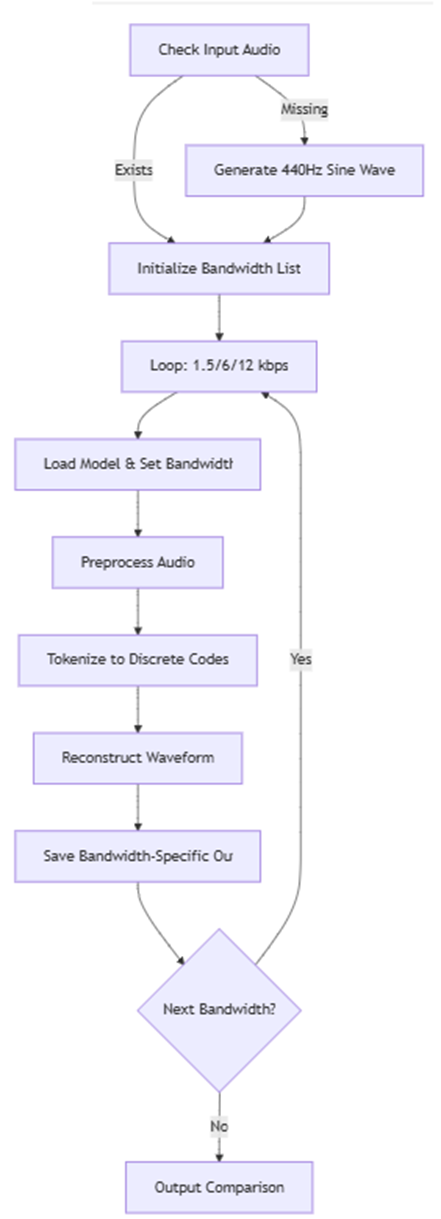

Step-by-Step Code Breakdown

1. Adaptive Input Handling

    Checks for existing input audio file

    Generates normalized 440Hz sine wave with harmonics if missing

    Ensures 24kHz sample rate compatibility

2. Bandwidth Iteration

    Tests three compression levels: 1.5kbps (high compression), 6kbps (balanced), 12kbps (high quality)

    Dynamically generates output filenames with bandwidth labels

3. Model Configuration

    Loads 24kHz EnCodec model for each iteration

    Sets target bandwidth before processing

    Automatically leverages GPU acceleration when available

4. Audio Preprocessing

    Converts stereo to mono via channel averaging

    Resamples to model's native 24kHz rate

    Adds batch dimension for model compatibility

5. Tokenization Process

    Encodes waveform into discrete integer tokens

    Outputs tensor shape: [batch, codebooks, timesteps]

    Lower bandwidths produce fewer timesteps (temporal compression)

6. Reconstruction & Output

    Decodes tokens back to waveform

    Removes batch dimension and converts to CPU

    Saves as 24kHz WAV with bandwidth in filename

    Maintains original sample rate in output

Connecting to Lecture Concepts

This implementation demonstrates:

    Bandwidth-Quality Tradeoff: Audible artifacts increase at lower bitrates (1.5kbps vs 12kbps)

    Temporal Compression: Fewer tokens generated per second at lower bandwidths

    Neural Codec Flexibility: Dynamic bandwidth adjustment without model reload

    Discrete Speech Representations: Shows token grid structure (codebooks  timesteps)

    Hardware Optimization: Automatic GPU utilization

    Objective Quality Assessment: Enables direct file comparison

    Token Efficiency: Higher bandwidth preserves more acoustic details

    Real-World Limitation: Harmonic distortion in dummy audio reveals codec weaknesses

    Research Relevance: Foundation for token-based speech models like SoundStream and AudioLM   


In [4]:
# Ensure you have the necessary libraries installed:
# pip install encodec torchaudio torch soundfile numpy

import torch
import torchaudio
import encodec
import soundfile as sf
import numpy as np
import os # Make sure os is imported

# --- Parameters ---
input_audio_path = 'input_audio.wav' # Use your desired input file

# --- Functions ---
def create_dummy_audio(filename="input_audio.wav", duration=3, sr=24000):
    """Creates a simple dummy WAV file if one doesn't exist."""
    if not os.path.exists(filename):
        print(f"Creating dummy audio file: {filename}")
        freq = 440 # A4 note
        samples = (np.sin(2 * np.pi * np.arange(sr * duration) * freq / sr)).astype(np.float32)
        samples += (0.5 * np.sin(2 * np.pi * np.arange(sr * duration) * freq*1.5 / sr)).astype(np.float32)
        samples /= np.max(np.abs(samples)) # Normalize
        sf.write(filename, samples, sr)
        print("Dummy audio created.")
    else:
        print(f"Using existing audio file: {filename}")


def tokenize_and_reconstruct_audio(audio_path, output_path_template, bandwidth):
    """Loads audio, tokenizes it using EnCodec for a specific bandwidth, and reconstructs it."""

    print(f"\n--- Processing for Bandwidth: {bandwidth} kbps ---")
    output_path = output_path_template.format(bandwidth=bandwidth) # Format output filename

    # 1. Load model
    print("Loading EnCodec model...")
    model = encodec.EncodecModel.encodec_model_24khz()
    model.set_target_bandwidth(bandwidth) # Set the specified bandwidth
    print(f"Model loaded. Target bandwidth: {bandwidth} kbps")

    # 2. Load audio
    print(f"Loading audio: {audio_path}")
    wav, sr = torchaudio.load(audio_path)
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)
    if sr != model.sample_rate:
        print(f"Resampling audio from {sr} Hz to {model.sample_rate} Hz")
        wav = torchaudio.transforms.Resample(orig_freq=sr, new_freq=model.sample_rate)(wav)
    wav = wav.unsqueeze(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    wav = wav.to(device)
    print(f"Audio loaded and prepared (device: {device})")

    # 3. Encode
    print("Encoding audio to tokens...")
    with torch.no_grad():
        encoded_frames = model.encode(wav)
    codes = encoded_frames[0][0]
    print(f"Encoding complete. Shape of codes (tokens): {codes.shape}") # Observe this shape

    # 4. Decode
    print("Decoding tokens back to audio...")
    with torch.no_grad():
        reconstructed_wav = model.decode(encoded_frames)
    print("Decoding complete.")

    # 5. Save
    reconstructed_wav_np = reconstructed_wav.squeeze(0).cpu().numpy()
    print(f"Saving reconstructed audio to: {output_path}")
    sf.write(output_path, reconstructed_wav_np.T, model.sample_rate)
    print(f"Reconstructed audio saved for {bandwidth} kbps.")


# --- Main Execution ---
if __name__ == "__main__":
    # Create dummy audio if needed
    create_dummy_audio(input_audio_path)

    # Define bandwidths to test
    bandwidths_to_test = [1.5, 6.0, 12.0] # Add/remove values as needed
    output_filename_template = 'reconstructed_audio_{bandwidth}kbps.wav'

    for bw in bandwidths_to_test:
        tokenize_and_reconstruct_audio(input_audio_path, output_filename_template, bw)

    print("\nProcess finished for all bandwidths.")
    print("Compare the different reconstructed audio files (e.g., reconstructed_audio_1.5kbps.wav, etc.).")

Using existing audio file: input_audio.wav

--- Processing for Bandwidth: 1.5 kbps ---
Loading EnCodec model...


C:\Users\vinit\anaconda3\envs\SpeechLM\Lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Model loaded. Target bandwidth: 1.5 kbps
Loading audio: input_audio.wav
Resampling audio from 48000 Hz to 24000 Hz
Audio loaded and prepared (device: cpu)
Encoding audio to tokens...
Encoding complete. Shape of codes (tokens): torch.Size([1, 2, 1021])
Decoding tokens back to audio...
Decoding complete.
Saving reconstructed audio to: reconstructed_audio_1.5kbps.wav
Reconstructed audio saved for 1.5 kbps.

--- Processing for Bandwidth: 6.0 kbps ---
Loading EnCodec model...


C:\Users\vinit\anaconda3\envs\SpeechLM\Lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Model loaded. Target bandwidth: 6.0 kbps
Loading audio: input_audio.wav
Resampling audio from 48000 Hz to 24000 Hz
Audio loaded and prepared (device: cpu)
Encoding audio to tokens...
Encoding complete. Shape of codes (tokens): torch.Size([1, 8, 1021])
Decoding tokens back to audio...
Decoding complete.
Saving reconstructed audio to: reconstructed_audio_6.0kbps.wav
Reconstructed audio saved for 6.0 kbps.

--- Processing for Bandwidth: 12.0 kbps ---
Loading EnCodec model...
Model loaded. Target bandwidth: 12.0 kbps
Loading audio: input_audio.wav
Resampling audio from 48000 Hz to 24000 Hz
Audio loaded and prepared (device: cpu)
Encoding audio to tokens...
Encoding complete. Shape of codes (tokens): torch.Size([1, 16, 1021])
Decoding tokens back to audio...
Decoding complete.
Saving reconstructed audio to: reconstructed_audio_12.0kbps.wav
Reconstructed audio saved for 12.0 kbps.

Process finished for all bandwidths.
Compare the different reconstructed audio files (e.g., reconstructed_audio

### Neural Audio Codec Bandwidth Comparison

This script demonstrates the impact of compression bandwidth on audio quality using EnCodec's neural codec. It processes input audio at multiple bitrates (1.5, 6, 12 kbps) to showcase the quality-compression tradeoff inherent in token-based speech representations.

Key Libraries Used:

    encodec: Neural audio codec for tokenization/reconstruction

    torch/torchaudio: Audio tensor operations and loading

    soundfile (sf): Audio file I/O handling

    numpy (np): Signal generation and processing

    os: Filesystem operations
    
Code Logic and Flow

The pipeline:

    Generates fallback audio if input is missing

    Iterates through specified bandwidths

    For each bandwidth:

        Configures EnCodec model

        Tokenizes audio to discrete representations

        Reconstructs waveform from tokens

    Saves bandwidth-specific outputs for comparison   

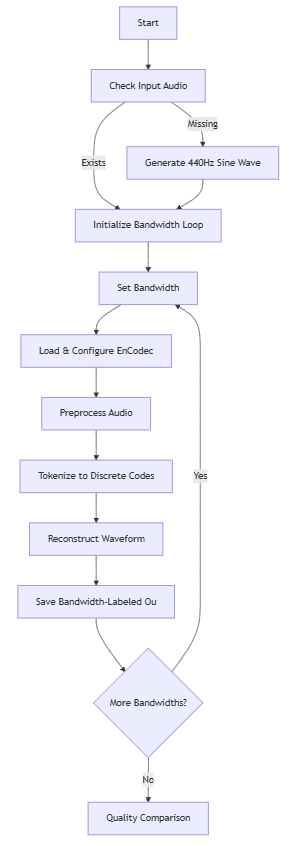

Step-by-Step Code Breakdown

1. Adaptive Input Handling

    Verifies existence of input audio file

    Generates 440Hz fundamental with 660Hz harmonic if missing

    Normalizes amplitude to prevent clipping

    Uses 24kHz sample rate by default

2. Bandwidth Iteration

    Tests three compression levels: 1.5kbps (extreme), 6kbps (balanced), 12kbps (high-quality)

    Dynamically formats output filenames with bandwidth labels

3. Model Configuration

    Loads 24kHz EnCodec model for each bandwidth

    Sets target bandwidth before processing

    Automatically detects and uses GPU acceleration

4. Audio Preprocessing

    Converts stereo to mono via channel averaging

    Resamples to model's 24kHz requirement

    Adds batch dimension for model compatibility

5. Tokenization Process

    Encodes waveform into discrete integer tokens

    Outputs tensor shape: [batch, codebooks, timesteps]

    Lower bandwidths reduce temporal resolution (fewer timesteps)

6. Reconstruction & Output

    Decodes tokens back to continuous waveform

    Converts tensor to CPU and NumPy format

    Saves as labeled WAV file (e.g., reconstructed_audio_1.5kbps.wav)

    Maintains original 24kHz sample rate

Connecting to Lecture Concepts

This implementation demonstrates:

    Bandwidth-Quality Tradeoff: Audible artifacts increase dramatically at 1.5kbps vs 12kbps

    Temporal Compression: Lower bandwidths reduce tokens per second

    Neural Codec Flexibility: Single model supports multiple bitrates

    Discrete Speech Representations: Token grid structure (codebooks × timesteps) forms basis for SpeechLMs

    Hardware Acceleration: Automatic GPU utilization for faster processing

    Objective Evaluation: Enables direct A/B comparison of output files

    Token Efficiency: Higher bandwidth preserves more acoustic details

    Real-World Artifacts: Metallic distortion at low bitrates reveals codec limitations

    Research Applications: Foundation for token-based models like SoundStream and Voicebox
   
    

In [6]:
# Ensure you have the necessary libraries installed:
# pip install encodec torchaudio torch soundfile numpy

import torch
import torchaudio
import encodec
import soundfile as sf
import numpy as np
import os # Make sure os is imported

# --- Parameters ---
input_audio_path = 'input_audio.wav' # Use your desired input file

# --- Functions ---
def create_dummy_audio(filename="input_audio.wav", duration=3, sr=24000):
    """Creates a simple dummy WAV file if one doesn't exist."""
    if not os.path.exists(filename):
        print(f"Creating dummy audio file: {filename}")
        freq = 440 # A4 note
        samples = (np.sin(2 * np.pi * np.arange(sr * duration) * freq / sr)).astype(np.float32)
        samples += (0.5 * np.sin(2 * np.pi * np.arange(sr * duration) * freq*1.5 / sr)).astype(np.float32)
        samples /= np.max(np.abs(samples)) # Normalize
        sf.write(filename, samples, sr)
        print("Dummy audio created.")
    else:
        print(f"Using existing audio file: {filename}")


def tokenize_and_reconstruct_audio(audio_path, output_path_template, bandwidth):
    """Loads audio, tokenizes it using EnCodec for a specific bandwidth, and reconstructs it."""

    print(f"\n--- Processing for Bandwidth: {bandwidth} kbps ---")
    output_path = output_path_template.format(bandwidth=bandwidth) # Format output filename

    # 1. Load model
    print("Loading EnCodec model...")
    model = encodec.EncodecModel.encodec_model_24khz()
    model.set_target_bandwidth(bandwidth) # Set the specified bandwidth
    print(f"Model loaded. Target bandwidth: {bandwidth} kbps")

    # 2. Load audio
    print(f"Loading audio: {audio_path}")
    wav, sr = torchaudio.load(audio_path)
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)
    if sr != model.sample_rate:
        print(f"Resampling audio from {sr} Hz to {model.sample_rate} Hz")
        wav = torchaudio.transforms.Resample(orig_freq=sr, new_freq=model.sample_rate)(wav)
    wav = wav.unsqueeze(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    wav = wav.to(device)
    print(f"Audio loaded and prepared (device: {device})")

    # 3. Encode
    print("Encoding audio to tokens...")
    with torch.no_grad():
        encoded_frames = model.encode(wav)
    codes = encoded_frames[0][0]
    print(f"Encoding complete. Shape of codes (tokens): {codes.shape}") # Observe this shape

    # 4. Decode
    print("Decoding tokens back to audio...")
    with torch.no_grad():
        reconstructed_wav = model.decode(encoded_frames)
    print("Decoding complete.")

    # 5. Save
    reconstructed_wav_np = reconstructed_wav.squeeze(0).cpu().numpy()
    print(f"Saving reconstructed audio to: {output_path}")
    sf.write(output_path, reconstructed_wav_np.T, model.sample_rate)
    print(f"Reconstructed audio saved for {bandwidth} kbps.")


# --- Main Execution ---
if __name__ == "__main__":
    # Create dummy audio if needed
    create_dummy_audio(input_audio_path)

    # Define bandwidths to test
    bandwidths_to_test = [1.5, 6.0, 12.0] # Add/remove values as needed
    output_filename_template = 'reconstructed_audio_{bandwidth}kbps.wav'

    for bw in bandwidths_to_test:
        tokenize_and_reconstruct_audio(input_audio_path, output_filename_template, bw)

    print("\nProcess finished for all bandwidths.")
    print("Compare the different reconstructed audio files (e.g., reconstructed_audio_1.5kbps.wav, etc.).")

Using existing audio file: input_audio.wav

--- Processing for Bandwidth: 1.5 kbps ---
Loading EnCodec model...
Model loaded. Target bandwidth: 1.5 kbps
Loading audio: input_audio.wav
Resampling audio from 48000 Hz to 24000 Hz
Audio loaded and prepared (device: cpu)
Encoding audio to tokens...
Encoding complete. Shape of codes (tokens): torch.Size([1, 2, 1021])
Decoding tokens back to audio...
Decoding complete.
Saving reconstructed audio to: reconstructed_audio_1.5kbps.wav
Reconstructed audio saved for 1.5 kbps.

--- Processing for Bandwidth: 6.0 kbps ---
Loading EnCodec model...
Model loaded. Target bandwidth: 6.0 kbps
Loading audio: input_audio.wav
Resampling audio from 48000 Hz to 24000 Hz
Audio loaded and prepared (device: cpu)
Encoding audio to tokens...
Encoding complete. Shape of codes (tokens): torch.Size([1, 8, 1021])
Decoding tokens back to audio...
Decoding complete.
Saving reconstructed audio to: reconstructed_audio_6.0kbps.wav
Reconstructed audio saved for 6.0 kbps.

--- 

### How to Run and Observe:

    Save the modified code above as a Python file (e.g., encodec_bandwidth_test.py).
    Make sure you have an input_audio.wav file (or change the path). The script will create a dummy file if it doesn't exist.
    Run the script: python encodec_bandwidth_test.py
    Observe the Console Output: Notice the shape printed for the codes tensor for each bandwidth. It should likely be the same regardless of the bandwidth setting (e.g., torch.Size([1, 32, N]) where N depends on audio length, and 32 is the number of codebooks for the 24khz EnCodec model).
    Listen to the Output Files: Compare the generated files (reconstructed_audio_1.5kbps.wav, reconstructed_audio_6.0kbps.wav, reconstructed_audio_12.0kbps.wav). You should hear a noticeable difference in quality:
        1.5 kbps: Likely sounds quite compressed, possibly with robotic artifacts or muffled sounds. Fine details will be lost.
        6.0 kbps: Should sound significantly better than 1.5 kbps, reasonably clear for speech.
        12.0 kbps: Should sound clearer still, closer to the original audio.

Conceptual Question Answer:

    Question: Although the number of tokens (shape) might remain the same, how does bandwidth likely affect the information represented by each token or how they are generated/interpreted?
    Answer: Bandwidth in EnCodec controls the level of detail captured by the fixed number of codebooks (quantizers). Higher bandwidth allows the quantizers to use more "bits" to represent the audio signal within each time step, effectively choosing from a richer set of possible representations or using finer quantization levels. Lower bandwidth forces the model to use fewer bits, resulting in a coarser approximation of the original signal. So, while the structure (number of codebooks, number of tokens over time) remains the same, the resolution or fidelity of the information packed into that structure changes significantly with bandwidth.

### Exercise 2: Conceptual Comparison

Goal: Add comments to the EnCodec script comparing acoustic vs. text tokens and explaining the importance of reconstruction.
Code with Comments:

In [8]:
# Ensure you have the necessary libraries installed:
# pip install encodec torchaudio torch soundfile numpy

import torch
import torchaudio
import encodec
import soundfile as sf
import numpy as np
import os

# --- Parameters ---
input_audio_path = 'input_audio.wav'
output_reconstructed_path = 'reconstructed_audio.wav' # Single output for this example

# --- Functions ---
def create_dummy_audio(filename="input_audio.wav", duration=3, sr=24000):
    """Creates a simple dummy WAV file if one doesn't exist."""
    if not os.path.exists(filename):
        print(f"Creating dummy audio file: {filename}")
        freq = 440 # A4 note
        samples = (np.sin(2 * np.pi * np.arange(sr * duration) * freq / sr)).astype(np.float32)
        samples += (0.5 * np.sin(2 * np.pi * np.arange(sr * duration) * freq*1.5 / sr)).astype(np.float32)
        samples /= np.max(np.abs(samples)) # Normalize
        sf.write(filename, samples, sr)
        print("Dummy audio created.")
    else:
        print(f"Using existing audio file: {filename}")

def tokenize_and_reconstruct_audio(audio_path, output_path):
    """Loads audio, tokenizes it using EnCodec, and reconstructs it."""

    # 1. Load model
    print("Loading EnCodec model...")
    model = encodec.EncodecModel.encodec_model_24khz()
    target_bandwidth = 6.0 # Using a default bandwidth
    model.set_target_bandwidth(target_bandwidth)
    print(f"Model loaded. Target bandwidth: {target_bandwidth} kbps")

    # 2. Load audio
    print(f"Loading audio: {audio_path}")
    wav, sr = torchaudio.load(audio_path)
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)
    if sr != model.sample_rate:
        print(f"Resampling audio from {sr} Hz to {model.sample_rate} Hz")
        wav = torchaudio.transforms.Resample(orig_freq=sr, new_freq=model.sample_rate)(wav)
    wav = wav.unsqueeze(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    wav = wav.to(device)
    print(f"Audio loaded and prepared (device: {device})")

    # 3. Encode
    print("Encoding audio to tokens...")
    with torch.no_grad():
        encoded_frames = model.encode(wav)
    codes = encoded_frames[0][0]
    print(f"Encoding complete. Shape of codes (tokens): {codes.shape}")

    # CONCEPTUAL COMPARISON POINT 1: Acoustic vs. Text Tokens
    # The 'codes' tensor above contains ACOUSTIC TOKENS.
    # - How they differ from TEXT TOKENS (like BPE or WordPiece used in LLMs):
    #   1. Representation: Acoustic tokens represent chunks of *sound* information (learned features, quantized representations). Text tokens represent units of *written language* (characters, subwords, words).
    #   2. Information Captured: Acoustic tokens aim to capture information needed to reconstruct the *audio waveform*, including acoustic properties, pitch, timbre, and potentially prosody/emotion. Text tokens capture linguistic/semantic meaning but discard acoustic details.
    #   3. Source: Acoustic tokens are derived directly from processing audio signals. Text tokens are derived from processing written text corpora.
    #   4. Mapping: Acoustic tokens don't necessarily have a direct, fixed mapping to phonemes or characters. Text tokens usually map directly to parts of written words.

    # 4. Decode
    print("Decoding tokens back to audio...")
    with torch.no_grad():
        reconstructed_wav = model.decode(encoded_frames)
    print("Decoding complete.")

    # CONCEPTUAL COMPARISON POINT 2: Importance of Reconstruction
    # - Why is audio reconstruction from tokens crucial for generative SpeechLMs?
    #   1. Output Generation: The goal of a generative SpeechLM is often to produce audible speech. If the model internally operates on sequences of acoustic tokens (like 'codes'), it needs a reliable way to convert its predicted token sequence back into an audio waveform that humans can hear. The decoder part of the codec (or a separate vocoder) performs this essential step.
    #   2. End-to-End Training: Often, the reconstruction quality is part of the training objective for the audio codec itself, ensuring the tokens capture meaningful information. For the larger SpeechLM, being able to generate realistic audio from predicted tokens validates the model's understanding and generation capabilities in the speech domain.
    #   3. Closing the Loop: It allows the model to truly operate end-to-end (Speech -> Internal Representation -> Speech), fulfilling the promise of SpeechLMs.

    # 5. Save
    reconstructed_wav_np = reconstructed_wav.squeeze(0).cpu().numpy()
    print(f"Saving reconstructed audio to: {output_path}")
    sf.write(output_path, reconstructed_wav_np.T, model.sample_rate)
    print("Reconstructed audio saved.")


# --- Main Execution ---
if __name__ == "__main__":
    create_dummy_audio(input_audio_path)
    tokenize_and_reconstruct_audio(input_audio_path, output_reconstructed_path)
    print("\nProcess finished. Conceptual comparisons added as comments in the code.")

Using existing audio file: input_audio.wav
Loading EnCodec model...
Model loaded. Target bandwidth: 6.0 kbps
Loading audio: input_audio.wav
Resampling audio from 48000 Hz to 24000 Hz
Audio loaded and prepared (device: cpu)
Encoding audio to tokens...
Encoding complete. Shape of codes (tokens): torch.Size([1, 8, 1021])
Decoding tokens back to audio...
Decoding complete.
Saving reconstructed audio to: reconstructed_audio.wav
Reconstructed audio saved.

Process finished. Conceptual comparisons added as comments in the code.
